GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /home/sandeep/Desktop/Windows files/HyPER-main/4_Top_results/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model           │ MPNNs          │ 14.0 K │ train │     0 │
│ 1 │ hyper           │ HyperedgeModel │  8.4 K │ train │     0 │
│ 2 │ criterion_edge  │ BCELoss        │      0 │ train │     0 │
│ 3 │ criterion_hyper │ BCELoss        │      0 │ train │     0 │
└───┴─────────────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 22.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 22.4 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 58                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connecto
r.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value 
of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

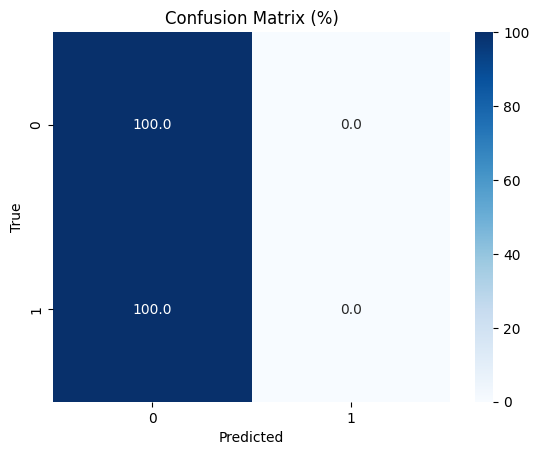

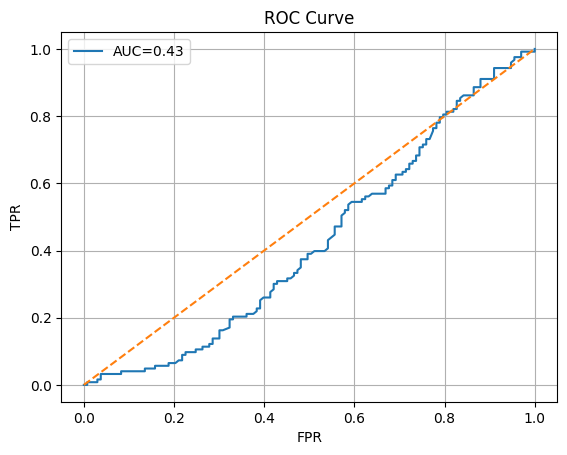

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_0.pkl

/home/sandeep/anaconda3/envs/gnnhep/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connecto
r.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

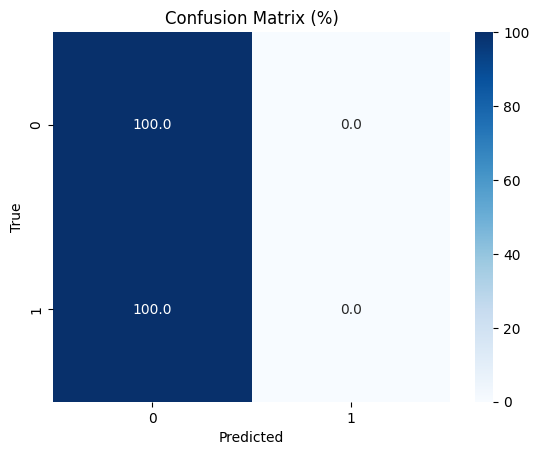

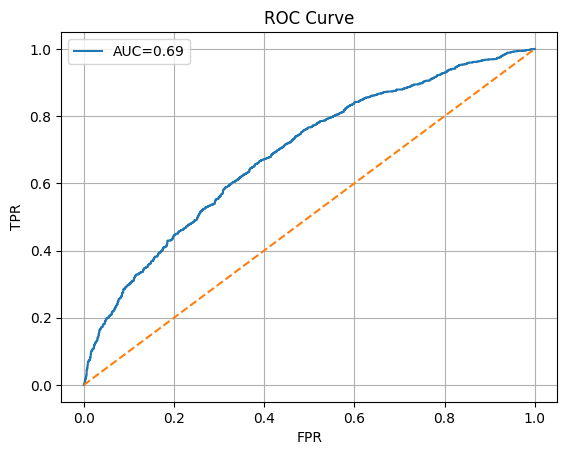

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_0.pkl

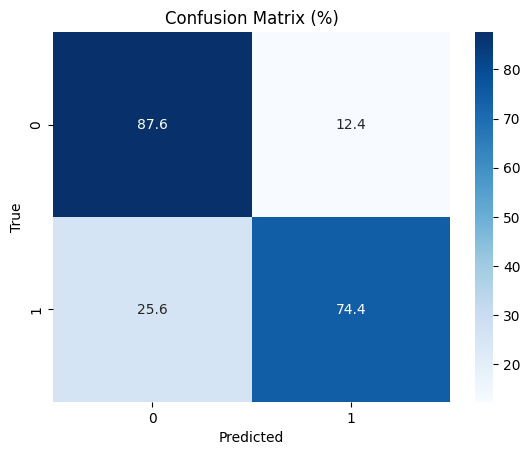

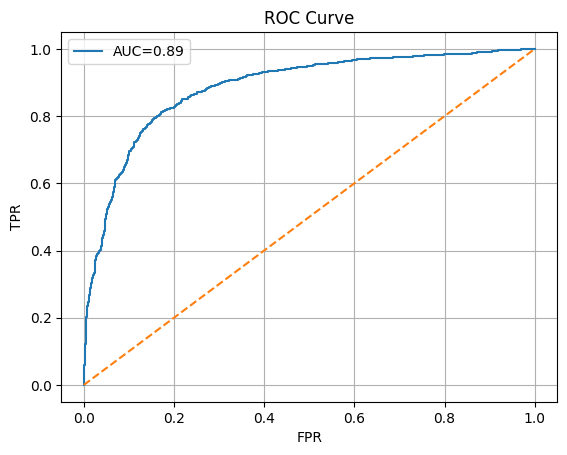

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_1.pkl

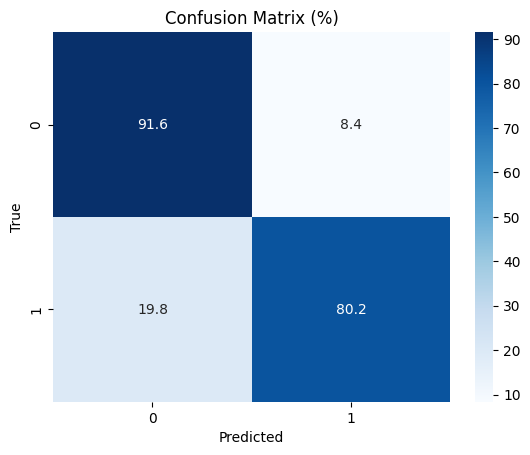

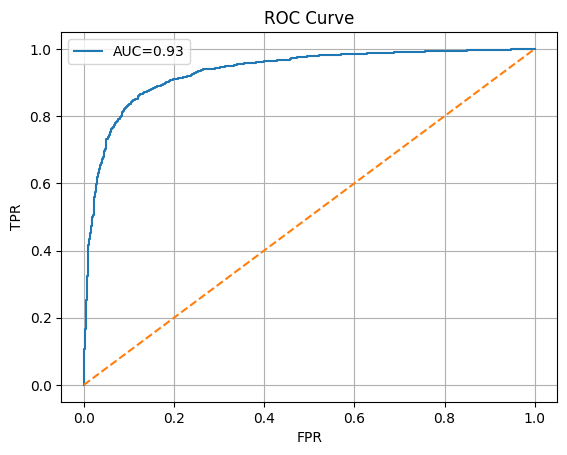

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_2.pkl

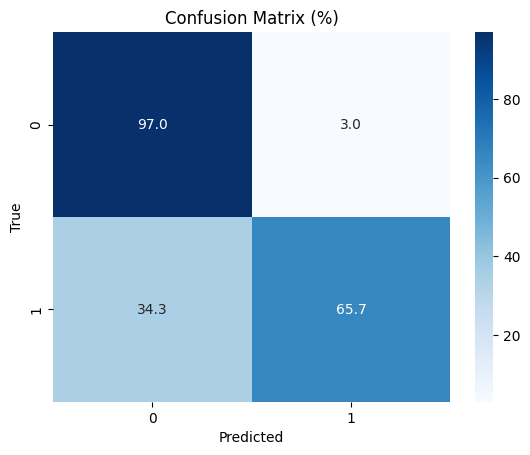

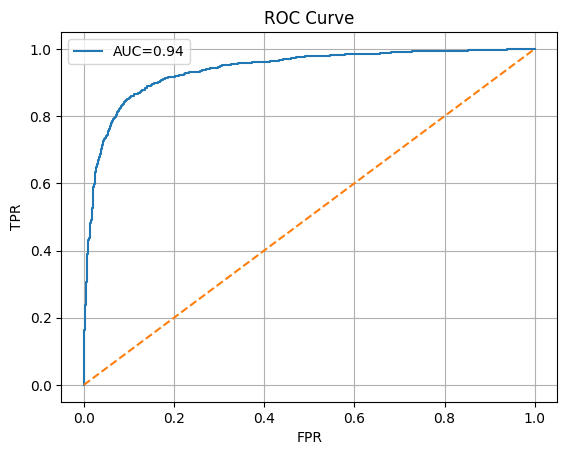

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_3.pkl

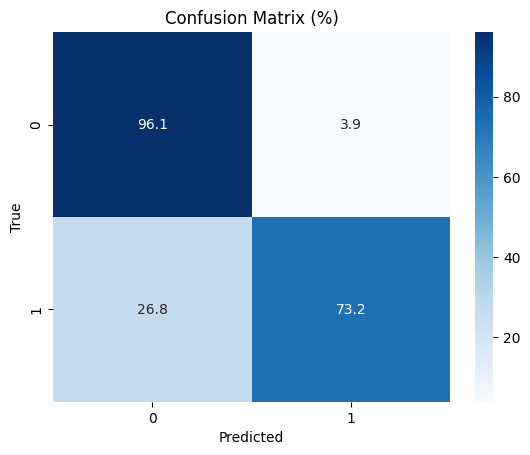

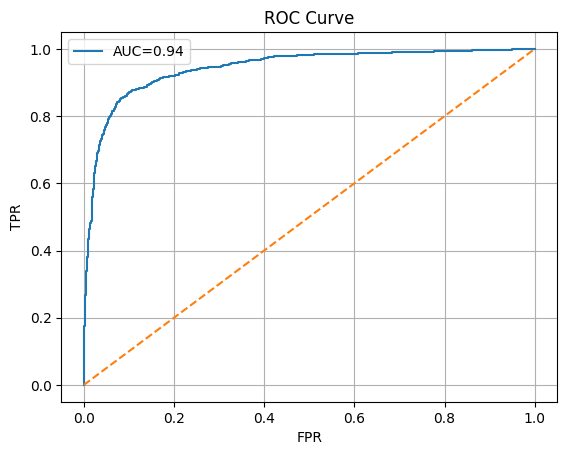

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_4.pkl

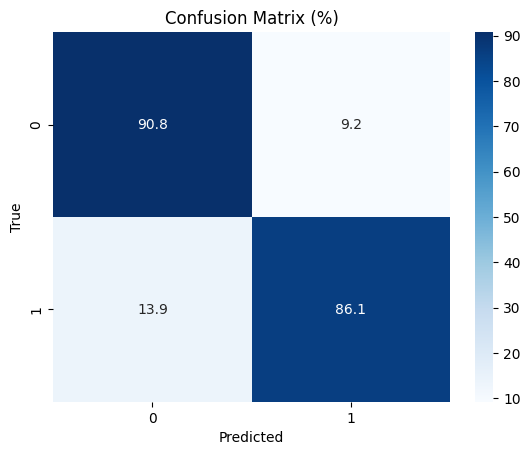

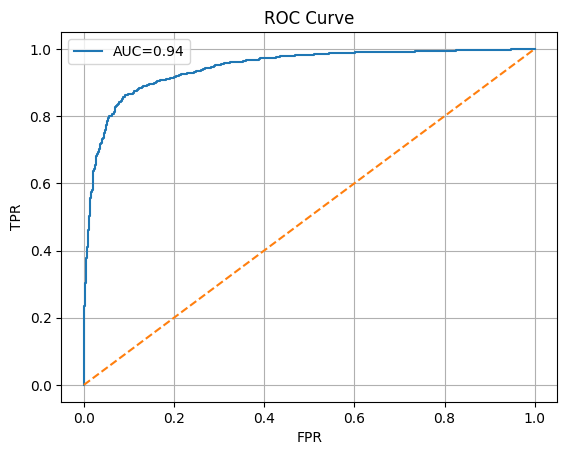

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_5.pkl

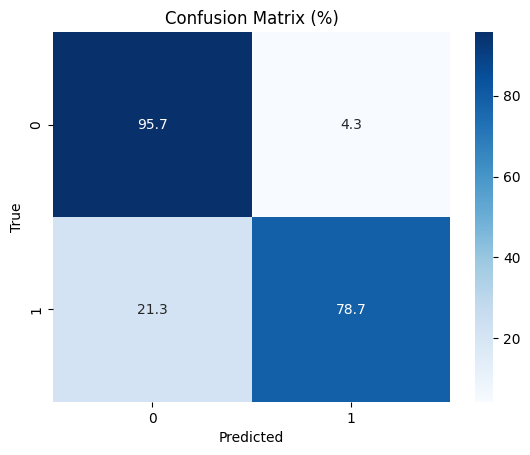

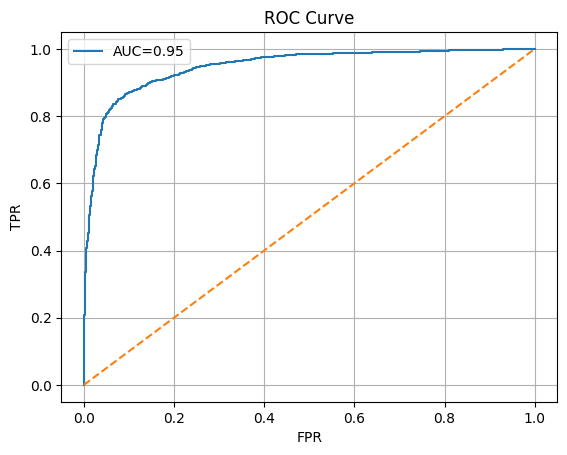

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_6.pkl

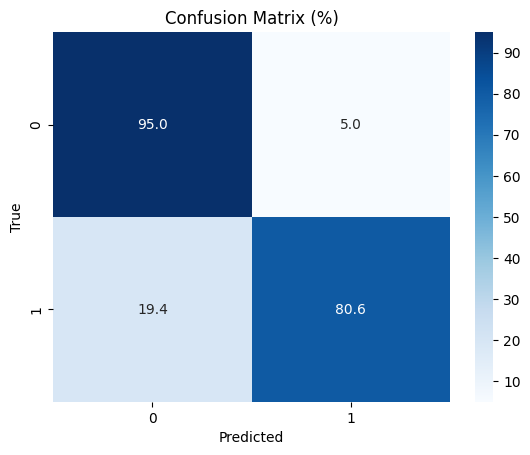

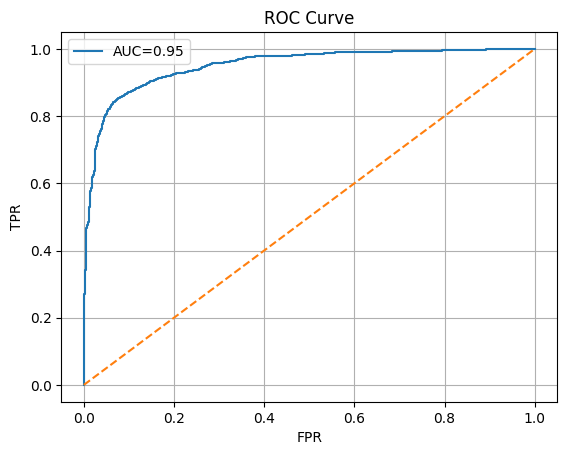

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_7.pkl

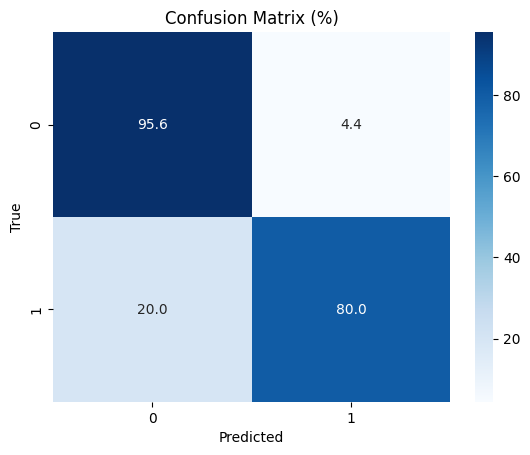

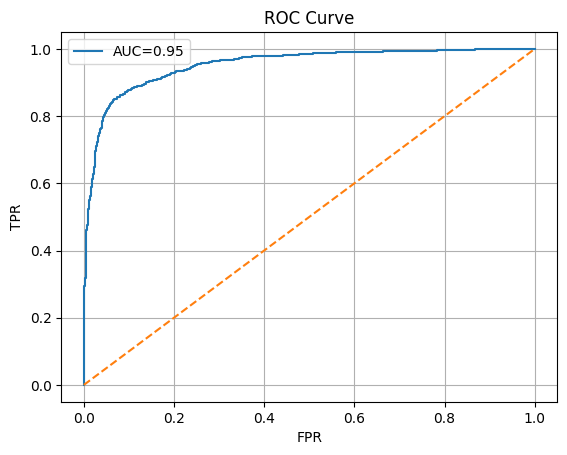

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_8.pkl

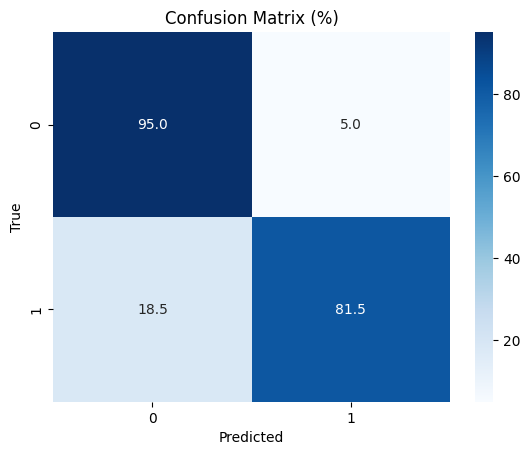

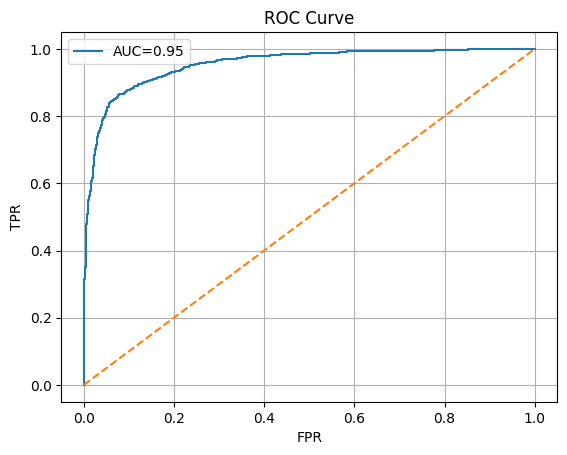

[INFO] Saved hyperedge physics to 4_Top_results/hyperedge_physics_epoch_9.pkl

`Trainer.fit` stopped: `max_epochs=10` reached.


In [49]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import uproot
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from torch.nn import BCELoss, Sigmoid
from torch.optim import Adam
from HyPER.models import MPNNs, HyperedgeModel, EdgeLoss, CombinedLoss
import seaborn as sns
import joblib
import os
from pytorch_lightning.callbacks import ModelCheckpoint
import pandas as pd


os.makedirs("4_Top_results", exist_ok=True)

# Configuration
checkpoint_cb = ModelCheckpoint(
    dirpath="4_Top_results/checkpoints",
    filename="hypergraph-{epoch:02d}-{val_loss:.4f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,   # best model
    save_last=True # final model
)

jet_features = [
    'Jet.PT', 'Jet.Phi', 'Jet.Mass', 'Jet.NCharged',
    'Jet.EhadOverEem', 'Jet.Eta', 'Jet.BTag',
    'Jet.Flavor', 'Jet.T', 'Jet.DeltaEta',
    'Jet.DeltaPhi', 'Jet.ChargedEnergyFraction',
    'Jet.NeutralEnergyFraction'
]

lepton_features = [
    'Electron.PT', 'Electron.Eta', 'Electron.Phi',
    'Muon.PT', 'Muon.Eta', 'Muon.Phi'
]

met_features = ['MissingET.MET', 'MissingET.Phi']
all_features = jet_features + lepton_features + met_features

signal_file = '/home/sandeep/Desktop/Windows files/project rootfiles/13TeV_signal_5k.root'
background_file =  '/home/sandeep/Desktop/Windows files/project rootfiles/ttbarH.root'

tree_name = 'Delphes'
batch_size = 128
delta_r_threshold = 0.9

# Helper functions

def delta_r(eta1, phi1, eta2, phi2):
    dphi = (phi1 - phi2 + np.pi) % (2*np.pi) - np.pi
    deta = eta1 - eta2
    return np.sqrt(deta**2 + dphi**2)

def normalize_features(x):
    if x.shape[0] == 0:
        return x
    return (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)

# Data conversion

def convert_to_hyper_data(x_all, eta_all, phi_all, label):
    N = x_all.shape[0]
    if N < 2:
        return None

    edge_index, edge_attr, edge_target = [], [], []

    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            dr = delta_r(eta_all[i], phi_all[i], eta_all[j], phi_all[j])
            edge_index.append([i, j])
            edge_attr.append([dr])
            edge_target.append(1 if dr < delta_r_threshold else 0)

    edge_index = torch.tensor(edge_index).T
    edge_attr_s = torch.tensor(edge_attr, dtype=torch.float)
    edge_attr_t = torch.tensor(edge_target, dtype=torch.float).view(-1, 1)

    hyperedges = []
    for j in range(N):
        members = [j]
        for k in range(N):
            if j != k and delta_r(eta_all[j], phi_all[j], eta_all[k], phi_all[k]) < delta_r_threshold:
                members.append(k)
        if len(members) > 1:
            hyperedges.append(members)

    if not hyperedges:
        return None

    node_ids = np.concatenate(hyperedges)
    hedge_ids = np.repeat(np.arange(len(hyperedges)), [len(h) for h in hyperedges])
    edge_index_h = torch.tensor(np.stack([node_ids, hedge_ids]), dtype=torch.long)

    u_s = torch.tensor([[x_all[:, 0].sum(), x_all[:, 1].mean()]], dtype=torch.float)

    return Data(
        x_s=torch.tensor(x_all, dtype=torch.float),
        edge_index=edge_index,
        edge_attr_s=edge_attr_s,
        edge_attr_s_batch=torch.zeros(edge_index.shape[1], dtype=torch.long),
        edge_attr_t=edge_attr_t,
        edge_index_h=edge_index_h,
        edge_index_h_batch=torch.zeros(edge_index_h.shape[1], dtype=torch.long),
        u_s=u_s,
        x_t=torch.tensor([label], dtype=torch.float),
        batch=torch.zeros(N, dtype=torch.long)
    )

def load_data(file_path, label):
    tree = uproot.open(file_path)[tree_name]
    events = tree.arrays(all_features, library='np')
    data_list = []

    for i in range(len(events[jet_features[0]])):
        # x_jets = normalize_features(np.column_stack([events[f][i] for f in jet_features]))
        x_jets_raw = np.column_stack([events[f][i] for f in jet_features])  # RAW (GeVand other param.)
        x_jets_raw = np.nan_to_num(x_jets_raw)
        n_jets = x_jets_raw.shape[0]


        x_jets = normalize_features(x_jets_raw.copy())
        # Leptons (pad to 13) to make consistent in dimensionality
        lep_blocks = []

        # electrons
        if len(events['Electron.PT'][i]) > 0:
            e = np.column_stack([events[f][i] for f in lepton_features[:3]])
            e = np.pad(e, ((0,0),(0,13 - e.shape[1])))
            lep_blocks.append(e)

        # muons
        if len(events['Muon.PT'][i]) > 0:
            m = np.column_stack([events[f][i] for f in lepton_features[3:]])
            m = np.pad(m, ((0,0),(0,13 - m.shape[1])))
            lep_blocks.append(m)

        if lep_blocks:
            x_leptons = normalize_features(np.vstack(lep_blocks))
        else:
            x_leptons = np.empty((0,13))

        # MET (pad to 13)
        met = np.array([events[f][i] for f in met_features]).reshape(1,-1)
        x_met = normalize_features(np.pad(met, ((0,0),(0,13 - met.shape[1]))))


        x_all = np.vstack([x_jets, x_leptons, x_met])

        eta_all = np.concatenate([x_jets[:,5], x_leptons[:,1] if len(x_leptons) else [], x_met[:,1]])
        phi_all = np.concatenate([x_jets[:,1], x_leptons[:,2] if len(x_leptons) else [], x_met[:,0]])

        data = convert_to_hyper_data(x_all, eta_all, phi_all, label)

        if data:
            #  attach raw jet pT (only jets, not leptons/MET)
            
            data.raw_pt = torch.tensor(x_jets_raw[:, 0], dtype=torch.float) 
            data.n_jets = n_jets
            data_list.append(data)


    return data_list

# Lightning Model

class HyPERModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.global_event_counter = 0

        self.val_probs = []
        self.val_labels = []


        self.model = MPNNs(
            node_in_channels=13,
            edge_in_channels=1,
            global_in_channels=2,
            node_out_channels=32,
            edge_out_channels=1,
            global_out_channels=32,
            message_feats=32,
            dropout=0.1,
            activation=Sigmoid(),
            p_out='edge'
        )

        self.hyper = HyperedgeModel(
            node_in_channels=32,
            node_out_channels=1,
            global_in_channels=32,
            message_feats=32,
            dropout=0.1
        )

        self.criterion_edge = BCELoss(reduction='none')
        self.criterion_hyper = BCELoss()
        self.alpha = 0.5

        self.hyperedge_log = []

    def forward(self, data):
        x, edge_attr, u = self.model(
            data.x_s, data.edge_index, data.edge_attr_s, data.u_s, data.batch
        )

        x_hat, batch_hyper = self.hyper(
            x,
            u,
            data.batch,
            data.edge_index_h,
            data.edge_index_h_batch,
            3  
         )


        return x_hat, batch_hyper, edge_attr

    def training_step(self, batch, batch_idx):
        x_hat, batch_hyper, edge_attr_prime = self.forward(batch)

        x_event_pred = torch.zeros_like(batch.x_t.float())
        for i in range(len(batch.x_t)):
            x_event_pred[i] = x_hat[batch_hyper == i].mean()

        loss_hyper = self.criterion_hyper(
            x_event_pred.view(-1), batch.x_t.float().view(-1)
        )

        loss_edge = EdgeLoss(
            edge_attr_prime.view(-1),
            batch.edge_attr_t.view(-1),
            batch.edge_attr_s_batch,
            self.criterion_edge,
            reduction='mean'
        )

        loss = CombinedLoss(loss_edge, loss_hyper, self.alpha, 'mean')

        # 🔹 logging
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.train_losses.append(loss.detach().cpu().item())

        return loss


    def validation_step(self, batch, batch_idx):
        x_hat, batch_hyper, _ = self.forward(batch)

        x_event_pred = torch.zeros_like(batch.x_t.float())
        for i in range(len(batch.x_t)):
            x_event_pred[i] = x_hat[batch_hyper == i].mean()

        val_loss = self.criterion_hyper(
            x_event_pred.view(-1), batch.x_t.float().view(-1)
        )

        self.log("val_loss", val_loss, on_epoch=True, prog_bar=True)

        # store for ROC / confusion matrix
        self.val_probs.extend(x_event_pred.detach().cpu().numpy())
        self.val_labels.extend(batch.x_t.detach().cpu().numpy())

        # Hyperedge  logging
        for h in range(len(x_hat)):
            nodes = batch.edge_index_h[0][batch.edge_index_h[1] == h]
            # jets = torch.unique(nodes[nodes < len(batch.x_s)])
            n_jets = batch.n_jets[batch_hyper[h]]
            jets = torch.unique(nodes[nodes < n_jets])


            if len(jets) < 3:
                continue

            pts = batch.raw_pt[jets].cpu().numpy()
            etas = batch.x_s[jets, 5].cpu().numpy()
            phis = batch.x_s[jets, 1].cpu().numpy()

            drs = [
                delta_r(etas[i], phis[i], etas[j], phis[j])
                for i in range(len(jets))
                for j in range(i + 1, len(jets))
            ]

            local_event_id = int(batch_hyper[h].item())
            global_event_id = self.global_event_counter + local_event_id

            self.hyperedge_log.append({
                "event_id": global_event_id,                    # for analysis
                "label": batch.x_t[local_event_id].item(),      # ✅ batch-safe
                "hyperedge_score": x_hat[h].item(),
                "mean_dr": float(np.mean(drs)),
                "max_dr": float(np.max(drs)),
                "n_jets": len(jets),
                "jet_pts": pts.tolist()
            })

        self.global_event_counter += len(batch.x_t)




    def on_validation_epoch_end(self):
        y_true = np.array(self.val_labels)
        y_score = np.array(self.val_probs)
        y_pred = (y_score > 0.5).astype(int)

        roc = roc_auc_score(y_true, y_score)
        self.log("val_roc_auc", roc, prog_bar=True)

        # confusion matrix 
        cm = confusion_matrix(y_true, y_pred)
        cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

        plt.figure()
        sns.heatmap(cm_pct, annot=True, fmt=".1f", cmap="Blues")
        plt.title("Confusion Matrix (%)")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC={roc:.2f}")
        plt.plot([0, 1], [0, 1], "--")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid()
        plt.show()
        torch.save(
            self.state_dict(),
            f"4_Top_results/hypergraph_weights_epoch_{self.current_epoch}.pt"
        )

        # reset
        self.val_probs.clear()
        self.val_labels.clear()

        out_file = f"4_Top_results/hyperedge_physics_epoch_{self.current_epoch}.pkl"
        joblib.dump(self.hyperedge_log, out_file)

        print(f"[INFO] Saved hyperedge physics to {out_file}")

        # clearing for next epoch
        self.hyperedge_log.clear()

    def configure_optimizers(self):
        opt = Adam(self.parameters(), lr=1e-3)
        sch = ReduceLROnPlateau(opt, mode='max', patience=10)
        return {"optimizer": opt, "lr_scheduler": sch, "monitor": "train_loss"}

# Run

signal = load_data(signal_file, 1)
background = load_data(background_file, 0)
dataset = signal + background
np.random.shuffle(dataset)

split = int(0.7 * len(dataset))
train_loader = DataLoader(dataset[:split], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset[split:], batch_size=batch_size)


trainer = Trainer(
    max_epochs=10,
    logger=TensorBoardLogger("lightning_logs", name="hypergraph"),
    callbacks=[checkpoint_cb],
    log_every_n_steps=4
)

trainer.fit(HyPERModel(), train_loader, val_loader)


In [50]:
df = pd.DataFrame(joblib.load("4_Top_results/hyperedge_physics_epoch_0.pkl"))

print(df["event_id"].nunique())
print(df.groupby("label")["event_id"].nunique())


10
label
0.0    8
1.0    2
Name: event_id, dtype: int64


In [51]:
dfs = []
for e in range(10):
    dfs.append(pd.DataFrame(joblib.load(
        f"4_Top_results/hyperedge_physics_epoch_{e}.pkl"
    )))

df = pd.concat(dfs, ignore_index=True)


In [52]:
print(os.listdir("4_Top_results"))
print(os.listdir("4_Top_results/checkpoints"))


['hypergraph_weights_epoch_11.pt', 'hypergraph_weights_epoch_6.pt', 'hypergraph_weights_epoch_18.pt', 'hyperedge_physics_epoch_9.pkl', 'hypergraph_weights_epoch_5.pt', 'hypergraph_weights_epoch_13.pt', 'hypergraph_weights_epoch_9.pt', 'hyperedge_physics_epoch_11.pkl', 'hyperedge_physics_epoch_8.pkl', 'hypergraph_weights_epoch_0.pt', 'hypergraph_weights_epoch_7.pt', 'hyperedge_physics_epoch_15.pkl', 'hypergraph_weights_epoch_15.pt', 'checkpoints', 'event_analysis', 'signal_vs_background', 'hyperedge_physics_epoch_2.pkl', 'hypergraph_weights_epoch_1.pt', 'hypergraph_weights_epoch_10.pt', 'hyperedge_physics_epoch_3.pkl', 'hypergraph_weights_epoch_4.pt', 'hyperedge_physics_epoch_18.pkl', 'hypergraph_weights_epoch_17.pt', 'hypergraph_weights_epoch_3.pt', 'hypergraph_weights_epoch_16.pt', 'hypergraph_weights_epoch_8.pt', 'hyperedge_physics_epoch_12.pkl', 'hyperedge_physics_epoch_7.pkl', 'hyperedge_physics_epoch_6.pkl', 'hypergraph_weights_epoch_19.pt', 'hyperedge_physics_epoch_1.pkl', 'hyper

In [56]:
df_sorted = df.sort_values("hyperedge_score", ascending=False)

print(
    df_sorted.head(20)[
        ["hyperedge_score", "mean_dr", "max_dr", "n_jets", "label"]
    ]
)


     hyperedge_score   mean_dr    max_dr  n_jets  label
97          0.994775  0.993762  1.383995       3    1.0
96          0.994018  0.965956  1.444592       3    1.0
220         0.981729  0.993762  1.383995       3    1.0
219         0.980023  0.965956  1.444592       3    1.0
383         0.977184  0.965956  1.444592       3    1.0
302         0.976855  0.993762  1.383995       3    1.0
384         0.976401  0.993762  1.383995       3    1.0
301         0.974845  0.965956  1.444592       3    1.0
260         0.973777  0.965956  1.444592       3    1.0
261         0.972091  0.993762  1.383995       3    1.0
343         0.968356  0.993762  1.383995       3    1.0
342         0.967534  0.965956  1.444592       3    1.0
179         0.964933  0.993762  1.383995       3    1.0
178         0.964723  0.965956  1.444592       3    1.0
137         0.922465  0.965956  1.444592       3    1.0
138         0.913788  0.993762  1.383995       3    1.0
55          0.853254  0.965956  1.444592       3

In [57]:
top5 = df_sorted.head(5)

for i, row in top5.iterrows():
    print("\n==============================")
    print(f"Score     : {row.hyperedge_score:.4f}")
    print(f"Label     : {row.label}")
    print(f"N jets    : {row.n_jets}")
    print(f"Mean ΔR   : {row.mean_dr:.3f}")
    print(f"Max ΔR    : {row.max_dr:.3f}")
    print(f"Jet pT    : {np.round(row.jet_pts, 1)}")



Score     : 0.9948
Label     : 1.0
N jets    : 3
Mean ΔR   : 0.994
Max ΔR    : 1.384
Jet pT    : [78.7 46.6 41.6]

Score     : 0.9940
Label     : 1.0
N jets    : 3
Mean ΔR   : 0.966
Max ΔR    : 1.445
Jet pT    : [220.5  78.7  46.6]

Score     : 0.9817
Label     : 1.0
N jets    : 3
Mean ΔR   : 0.994
Max ΔR    : 1.384
Jet pT    : [78.7 46.6 41.6]

Score     : 0.9800
Label     : 1.0
N jets    : 3
Mean ΔR   : 0.966
Max ΔR    : 1.445
Jet pT    : [220.5  78.7  46.6]

Score     : 0.9772
Label     : 1.0
N jets    : 3
Mean ΔR   : 0.966
Max ΔR    : 1.445
Jet pT    : [220.5  78.7  46.6]


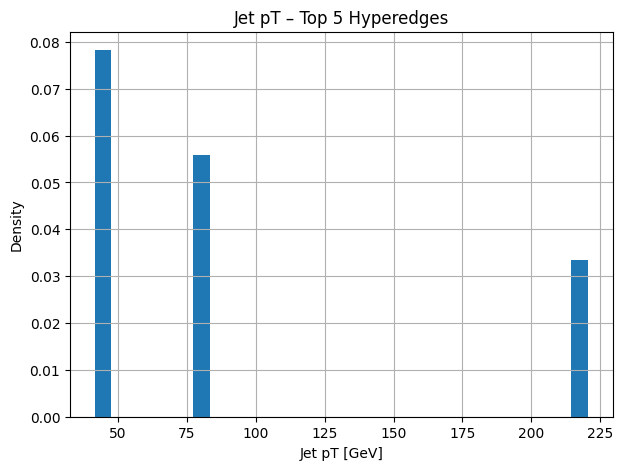

In [58]:
top5_pts = np.concatenate(top5["jet_pts"].values)

plt.figure(figsize=(7,5))
plt.hist(top5_pts, bins=30, density=True)
plt.xlabel("Jet pT [GeV]")
plt.ylabel("Density")
plt.title("Jet pT – Top 5 Hyperedges")
plt.grid()
plt.show()


In [71]:
# bottom15 = df_sorted.tail(15)

# plt.figure(figsize=(7,5))
# plt.hist(top5["mean_dr"], bins=10, alpha=0.5, label="Top 5", density=True)
# plt.hist(bottom15["mean_dr"], bins=10, alpha=0.7, label="Bottom 5", density=True)
# plt.xlabel("Mean ΔR")
# plt.ylabel("Density")
# plt.title("Mean ΔR: Top vs Bottom Hyperedges")
# plt.legend()
# plt.grid()
# plt.show()


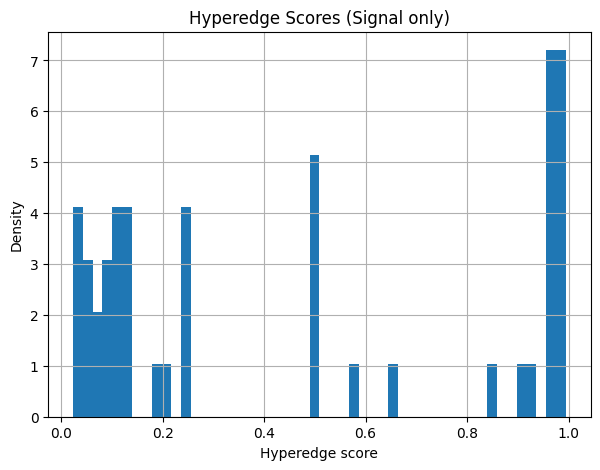

In [72]:
sig = df[df["label"] == 1]

plt.figure(figsize=(7,5))
plt.hist(sig["hyperedge_score"], bins=50, density=True)
plt.xlabel("Hyperedge score")
plt.ylabel("Density")
plt.title("Hyperedge Scores (Signal only)")
plt.grid()
plt.show()


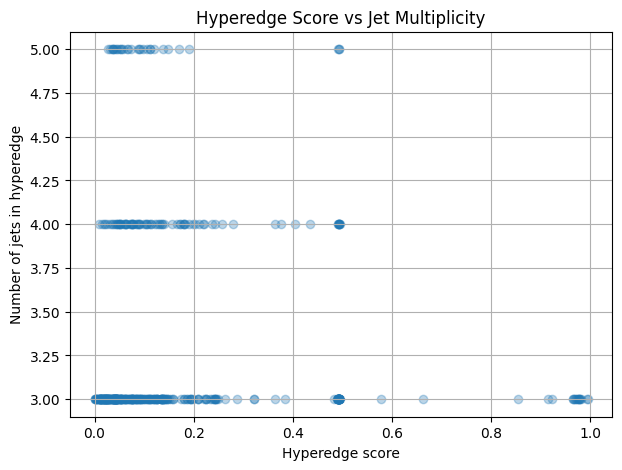

In [61]:
plt.figure(figsize=(7,5))
plt.scatter(df["hyperedge_score"], df["n_jets"], alpha=0.3)
plt.xlabel("Hyperedge score")
plt.ylabel("Number of jets in hyperedge")
plt.title("Hyperedge Score vs Jet Multiplicity")
plt.grid()
plt.show()


Columns: ['event_id', 'label', 'hyperedge_score', 'mean_dr', 'max_dr', 'n_jets', 'jet_pts']
Total hyperedges: 410

Hyperedges per event:
event_id
256      6
384      5
512      3
640      2
896      1
        ..
28174    9
28558    1
28814    4
28942    7
29966    3
Length: 100, dtype: int64

Signal vs background hyperedges:
label
0.0    360
1.0     50
dtype: int64

Using SIGNAL event_id = 512

Event-level table:
    hyperedge_score   mean_dr    max_dr  n_jets
13         0.492845  0.508347  0.620053       3
12         0.492359  0.508347  0.620053       3
11         0.490339  0.508347  0.620053       3


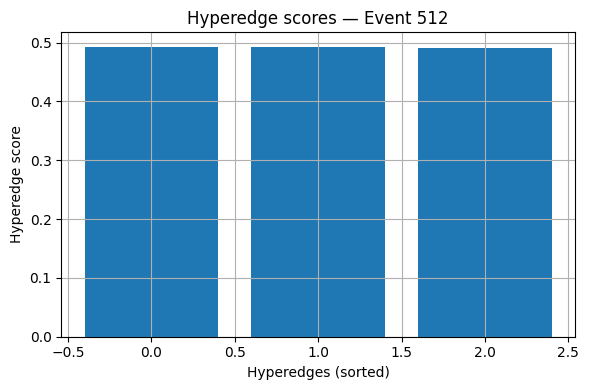

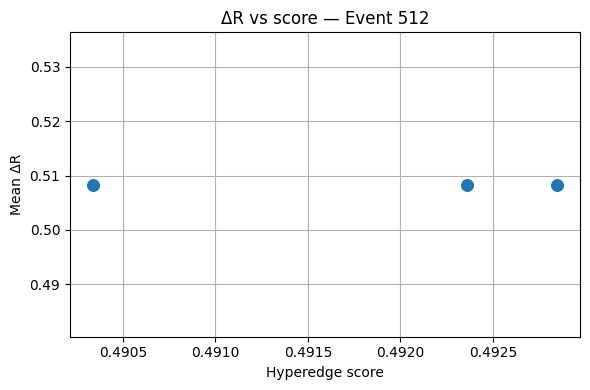


Top hyperedges:

----------------------------------
Hyperedge score : 0.4928
N jets          : 3
Mean ΔR         : 0.5083
Max ΔR          : 0.6201
Jet pT [GeV]    : [135.1  43.4  30.9]

----------------------------------
Hyperedge score : 0.4924
N jets          : 3
Mean ΔR         : 0.5083
Max ΔR          : 0.6201
Jet pT [GeV]    : [135.1  43.4  30.9]

----------------------------------
Hyperedge score : 0.4903
N jets          : 3
Mean ΔR         : 0.5083
Max ΔR          : 0.6201
Jet pT [GeV]    : [135.1  43.4  30.9]


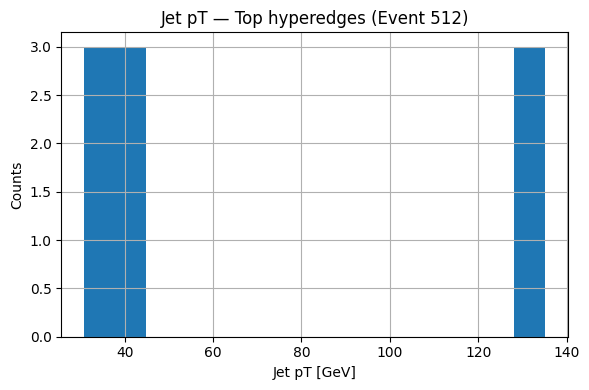


Saved event table to 4_Top_results/event_analysis/event_512_hyperedges.csv

DONE.


In [ ]:

OUT_DIR = "4_Top_results/event_analysis"
os.makedirs(OUT_DIR, exist_ok=True)

print("Columns:", df.columns.tolist())
print("Total hyperedges:", len(df))

required_cols = {
    "event_id", "label", "hyperedge_score",
    "mean_dr", "max_dr", "n_jets", "jet_pts"
}
assert required_cols.issubset(df.columns), "Missing required columns"

# BASIC SUMMARY

print("\nHyperedges per event:")
print(df.groupby("event_id").size())

print("\nSignal vs background hyperedges:")
print(df.groupby("label").size())

# PICKING ONE EVENT

signal_events = df[df["label"] == 1]["event_id"].unique()

if len(signal_events) > 0:
    event_id = signal_events[0]
    print(f"\nUsing SIGNAL event_id = {event_id}")
else:
    event_id = df["event_id"].iloc[0]
    print(f"\nNo signal found, using event_id = {event_id}")

evt = df[df["event_id"] == event_id].sort_values(
    "hyperedge_score", ascending=False
)

print("\nEvent-level table:")
print(evt[["hyperedge_score", "mean_dr", "max_dr", "n_jets"]])

# PLOT 1 — Hyperedge scores (event-by-event)

plt.figure(figsize=(6, 4))
plt.bar(range(len(evt)), evt["hyperedge_score"])
plt.xlabel("Hyperedges (sorted)")
plt.ylabel("Hyperedge score")
plt.title(f"Hyperedge scores — Event {event_id}")
plt.grid()
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/event_{event_id}_scores.png")
plt.show()

# PLOT 2 — ΔR vs score 

plt.figure(figsize=(6, 4))
plt.scatter(evt["hyperedge_score"], evt["mean_dr"], s=70)
plt.xlabel("Hyperedge score")
plt.ylabel("Mean ΔR")
plt.title(f"ΔR vs score — Event {event_id}")
plt.grid()
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/event_{event_id}_dr_vs_score.png")
plt.show()

# TOP-K HYPEREDGES 

K = len(evt)
topK = evt.head(K)

print("\nTop hyperedges:")

for i, row in topK.iterrows():
    print("\n----------------------------------")
    print(f"Hyperedge score : {row.hyperedge_score:.4f}")
    print(f"N jets          : {row.n_jets}")
    print(f"Mean ΔR         : {row.mean_dr:.4f}")
    print(f"Max ΔR          : {row.max_dr:.4f}")
    print(f"Jet pT [GeV]    : {np.round(row.jet_pts, 1)}")

# PLOT 3 — Jet pT spectrum (top hyperedges only)

top_pts = np.concatenate(topK["jet_pts"].values)

plt.figure(figsize=(6, 4))
plt.hist(top_pts, bins=15)
plt.xlabel("Jet pT [GeV]")
plt.ylabel("Counts")
plt.title(f"Jet pT — Top hyperedges (Event {event_id})")
plt.grid()
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/event_{event_id}_jet_pt.png")
plt.show()

evt.to_csv(f"{OUT_DIR}/event_{event_id}_hyperedges.csv", index=False)
print(f"\nSaved event table to {OUT_DIR}/event_{event_id}_hyperedges.csv")

print("\nDONE.")


Columns: ['event_id', 'label', 'hyperedge_score', 'mean_dr', 'max_dr', 'n_jets', 'jet_pts']
Total hyperedges: 410

Hyperedges per global event:
global_event_id
0_10330    9
0_10714    1
0_10970    4
0_11098    7
0_12122    3
          ..
1_640      2
1_6460     3
1_6588     2
1_9434     3
1_9562     2
Length: 100, dtype: int64

Signal vs background hyperedges:
label
0.0    360
1.0     50
dtype: int64

Signal events: ['1_512', '1_640', '1_3486', '1_3614', '1_6460', '1_6588', '1_9434', '1_9562', '1_12408', '1_12536', '1_15382', '1_15510', '1_18356', '1_18484', '1_21330', '1_21458', '1_24304', '1_24432', '1_27278', '1_27406']
Background events: ['0_256', '0_384', '0_896', '0_1408', '0_1792', '0_2048', '0_2176', '0_3200', '0_3230', '0_3358', '0_3870', '0_4382', '0_4766', '0_5022', '0_5150', '0_6174', '0_6204', '0_6332', '0_6844', '0_7356', '0_7740', '0_7996', '0_8124', '0_9148', '0_9178', '0_9306', '0_9818', '0_10330', '0_10714', '0_10970']

===== SIGNAL EVENT 1_512 =====
    hyperedge_sco

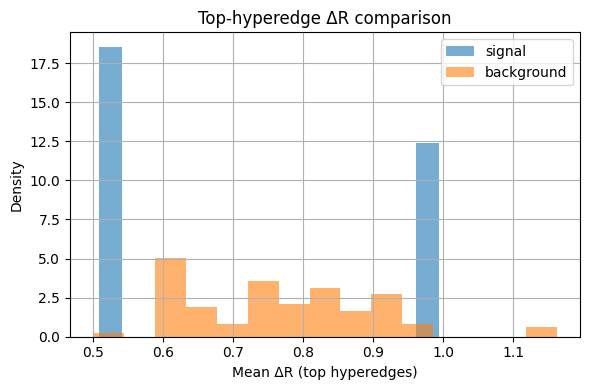

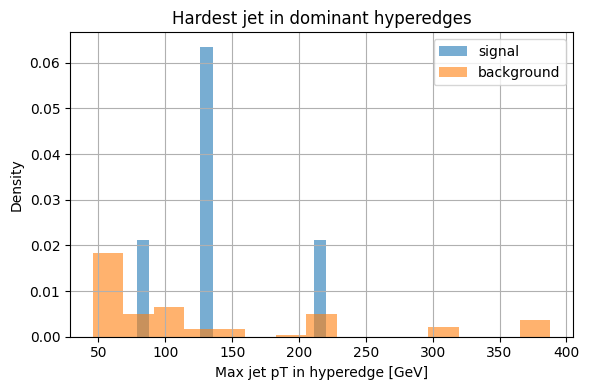

In [ ]:

OUT_DIR = "4_Top_results/event_analysis"
os.makedirs(OUT_DIR, exist_ok=True)

N_SIGNAL_EVENTS = 30
N_BACKGROUND_EVENTS = 30
TOP_K = 5

print("Columns:", df.columns.tolist())
print("Total hyperedges:", len(df))

required_cols = {
    "event_id", "label", "hyperedge_score",
    "mean_dr", "max_dr", "n_jets", "jet_pts"
}
assert required_cols.issubset(df.columns), "Missing required columns"

# FIXING EVENT ID COLLISION 

df["global_event_id"] = (
    df["label"].astype(int).astype(str)
    + "_"
    + df["event_id"].astype(int).astype(str)
)


print("\nHyperedges per global event:")
print(df.groupby("global_event_id").size())

print("\nSignal vs background hyperedges:")
print(df.groupby("label").size())

# SELECT EVENTS

signal_event_ids = (
    df[df["label"] == 1]["global_event_id"]
    .drop_duplicates()
    .iloc[:N_SIGNAL_EVENTS]
    .tolist()
)

background_event_ids = (
    df[df["label"] == 0]["global_event_id"]
    .drop_duplicates()
    .iloc[:N_BACKGROUND_EVENTS]
    .tolist()
)

print("\nSignal events:", signal_event_ids)
print("Background events:", background_event_ids)

# EVENT ANALYSIS FUNCTION

all_top_rows = []

def analyze_event(global_event_id, label_name):
    evt = df[df["global_event_id"] == global_event_id].sort_values(
        "hyperedge_score", ascending=False
    )

    print(f"\n===== {label_name.upper()} EVENT {global_event_id} =====")
    print(evt[["hyperedge_score", "mean_dr", "max_dr", "n_jets"]])

    #Hyperedge scores
    plt.figure(figsize=(6,4))
    plt.bar(range(len(evt)), evt["hyperedge_score"])
    plt.xlabel("Hyperedges (sorted)")
    plt.ylabel("Hyperedge score")
    plt.title(f"{label_name} event {global_event_id}: hyperedge scores")
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/{label_name}_{global_event_id}_scores.png")
    plt.close()

    # ΔR vs score
    plt.figure(figsize=(6,4))
    plt.scatter(evt["hyperedge_score"], evt["mean_dr"], s=70)
    plt.xlabel("Hyperedge score")
    plt.ylabel("Mean ΔR")
    plt.title(f"{label_name} event {global_event_id}: ΔR vs score")
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/{label_name}_{global_event_id}_dr_vs_score.png")
    plt.close()

    # Jet pT spectrum (top K)
    topK = evt.head(TOP_K)
    top_pts = np.concatenate(topK["jet_pts"].values)

    plt.figure(figsize=(6,4))
    plt.hist(top_pts, bins=15)
    plt.xlabel("Jet pT [GeV]")
    plt.ylabel("Counts")
    plt.title(f"{label_name} event {global_event_id}: jet pT (top {TOP_K})")
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/{label_name}_{global_event_id}_jet_pt.png")
    plt.close()

    evt.to_csv(
        f"{OUT_DIR}/{label_name}_{global_event_id}_hyperedges.csv",
        index=False
    )

    #Collect for combined plots
    for _, r in topK.iterrows():
        all_top_rows.append({
            "label": label_name,
            "global_event_id": global_event_id,
            "hyperedge_score": r.hyperedge_score,
            "mean_dr": r.mean_dr,
            "n_jets": r.n_jets,
            "max_jet_pt": max(r.jet_pts),
            "sum_jet_pt": sum(r.jet_pts)
        })


for gid in signal_event_ids:
    analyze_event(gid, "signal")

for gid in background_event_ids:
    analyze_event(gid, "background")


comb = pd.DataFrame(all_top_rows)

# ΔR comparison
plt.figure(figsize=(6,4))
for lbl in ["signal", "background"]:
    subset = comb[comb.label == lbl]
    plt.hist(
        subset.mean_dr,
        bins=15,
        alpha=0.6,
        density=True,
        label=lbl
    )

plt.xlabel("Mean ΔR (top hyperedges)")
plt.ylabel("Density")
plt.title("Top-hyperedge ΔR comparison")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/compare_mean_dr.png")
plt.show()

# Max jet pT comparison
plt.figure(figsize=(6,4))
for lbl in ["signal", "background"]:
    subset = comb[comb.label == lbl]
    plt.hist(
        subset.max_jet_pt,
        bins=15,
        alpha=0.6,
        density=True,
        label=lbl
    )

plt.xlabel("Max jet pT in hyperedge [GeV]")
plt.ylabel("Density")
plt.title("Hardest jet in dominant hyperedges")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/compare_max_jet_pt.png")
plt.show()



In [69]:
max_score_per_event = df.groupby("global_event_id")["hyperedge_score"].max()
max_score_per_event.head(15)

global_event_id
0_10330    0.198990
0_10714    0.039865
0_10970    0.088983
0_11098    0.180250
0_12122    0.207892
0_12152    0.130030
0_12280    0.139707
0_12792    0.019445
0_13304    0.179545
0_13688    0.025442
0_13944    0.066985
0_14072    0.137671
0_1408     0.494916
0_15096    0.157873
0_15126    0.384484
Name: hyperedge_score, dtype: float64

In [65]:
print("\nUnique signal global events:")
print(
    df[df["label"] == 1]["global_event_id"]
    .value_counts()
)

print("\nUnique background global events:")
print(
    df[df["label"] == 0]["global_event_id"]
    .value_counts()
)



Unique signal global events:
global_event_id
1_512      3
1_12408    3
1_27278    3
1_24304    3
1_21330    3
1_18356    3
1_15382    3
1_9434     3
1_6460     3
1_3486     3
1_9562     2
1_12536    2
1_640      2
1_15510    2
1_6588     2
1_18484    2
1_21458    2
1_3614     2
1_24432    2
1_27406    2
Name: count, dtype: int64

Unique background global events:
global_event_id
0_16278    9
0_7356     9
0_1408     9
0_28174    9
0_19252    9
          ..
0_22610    1
0_4766     1
0_21714    1
0_19636    1
0_9818     1
Name: count, Length: 80, dtype: int64
